In [1]:
%matplotlib inline
import matplotlib.ticker as mticker
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
suds=['re.session.login3.hrlee.018573.0001',
 're.session.login3.hrlee.018573.0002',
 're.session.login3.hrlee.018572.0007']

In [3]:
ss = {}
for sid in suds:
    sp = sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

In [4]:
for sid in suds:
    ss[sid].update({'sid'     : ss[sid]['s'].uid,
                    'pid'     : ss[sid]['p'].list('uid'),
                    'expid'   : sid,
                    'npilot'  : len(ss[sid]['p'].get()),
                    'lm'      : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact'   : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit'   : len(ss[sid]['u'].get()),
                    'nudone'  : len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail'  : len(ss[sid]['u'].timestamps(state='FAILED')),
                    'hostid'  : ss[sid]['s'].get(etype='pilot')[0].cfg['hostid'],
                    'gpu_node': ss[sid]['s'].get(etype='pilot')[0].cfg['gpus_per_node']})
    ss[sid].update({'pres'    : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus'   : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})
    ss[sid].update({'nnodes'  : int(ss[sid]['ngpus']/ss[sid]['gpu_node'])})

In [5]:
info = []
for sid in suds:
    info.append({'session'  : sid,
                 'exp_id'   : sid,
                 'resource' : ss[sid]['pres'],
                 'pilot_lm' : ss[sid]['lm'], 
                 'pilots'   : ss[sid]['npilot'],
                 'ps_active': ss[sid]['npact'],
                 'cores'    : ss[sid]['ncores']/4, 
                 'gpus'     : ss[sid]['ngpus'], 
                 'nodes'    : ss[sid]['nnodes'], 
                 'tasks'    : ss[sid]['nunit'], 
                 'ts_done'  : ss[sid]['nudone'],  
                 'ts_failed': ss[sid]['nufail']})

df_info = pd.DataFrame(info) 

In [6]:
u_durations = {}

for sid in suds:
    u_durations[sid] = {}

for sid in suds:
    for uid in ss[sid]['u'].list('uid'):
        unit = ss[sid]['u'].get(etype='unit', uid=uid)[0]
        durations = {}
        for k,v in rp.utils.UNIT_DURATIONS_DEBUG.items():
            try:
                durations[k] = unit.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, uid, v))
                durations[k] = 0
        u_durations[sid].update({uid: durations})

In [7]:
p_durations = {}

for sid in suds:
    p_durations[sid] = {}

for sid in suds:
    for pid in ss[sid]['p'].list('uid'):
        pilot = ss[sid]['p'].get(etype='pilot', uid=pid)[0]
        durations = {}
        for k,v in rp.utils.PILOT_DURATIONS_DEBUG.items():
            try:
                durations[k] = pilot.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, pid, v))
                durations[k] = 0
        p_durations[sid].update({pid: durations})

In [8]:
for sid in suds:
    w  = ss[sid]['w']
    u  = ss[sid]['u']
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'bootstrap_0_start', ru.STATE: None   },
                                 # {ru.EVENT: 'bootstrap_0_stop', ru.STATE: None    }]),
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE    },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED  },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED}]]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None       },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None       } ])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_p'] - ss[sid]['ttx_u']})

In [9]:
ovh_rtc = {}
ttx_u = {}
for sid in ss:
    expid = ss[sid]['expid']
    if expid not in ovh_rtc.keys():
        ovh_rtc[expid] = []
        ttx_u[expid] = []
    ovh_rtc[expid].append(ss[sid]['ovh_rtc'])
    ttx_u[expid].append(ss[sid]['ttx_u'])
#     if expid == 'PLC-4':
#         display("%s: %s" % (sid,ss[sid]['ttx_u']))

pcl_overheads = []
for expid in ovh_rtc.keys():
    pcl_overheads.append({'Exp. ID' : expid, 
                          'TTX': np.mean(ttx_u[expid]),
                          'OVH': np.mean(ovh_rtc[expid])})

df_pcl_overheads = pd.DataFrame(pcl_overheads) 
df_pcl_overheads

,Exp. ID,TTX,OVH
0,re.session.login3.hrlee.018573.0001,3724.0,2040.713947
1,re.session.login3.hrlee.018573.0002,4351.0,1432.882596
2,re.session.login3.hrlee.018572.0007,5125.0,652.270983


### Manual adjustment

In [10]:
last_unit_ends = unit_000013_ends_re_session_login3_hrlee_018573_0001 = 1604839597.3188933620
first_unit_starts = unit_000000_starts_re_session_login3_hrlee_018573_0001 = 1604833943
pcl_overheads[0]['TTX'] = last_unit_ends - first_unit_starts
sid = pcl_overheads[0]['Exp. ID']
pcl_overheads[0]['OVH'] = ss[sid]['ttx_p'] - pcl_overheads[0]['TTX']
last_unit_ends = unit_000018_ends_re_session_login3_hrlee_018573_0002 = 1604842419.8927597490
first_unit_starts = unit_000000_starts_re_session_login3_hrlee_018573_0002 = 1604836764
pcl_overheads[1]['TTX'] = last_unit_ends - first_unit_starts
sid = pcl_overheads[1]['Exp. ID']
pcl_overheads[1]['OVH'] = ss[sid]['ttx_p'] - pcl_overheads[0]['TTX']
last_unit_ends = unit_000034_ends_re_session_login3_hrlee_018572_0007 = 1604846732.5178431650
first_unit_starts = unit_000000_starts_re_session_login3_hrlee_018572_0007 = 1604841480
pcl_overheads[2]['TTX'] = last_unit_ends - first_unit_starts
sid = pcl_overheads[2]['Exp. ID']
pcl_overheads[2]['OVH'] = ss[sid]['ttx_p'] - pcl_overheads[0]['TTX']
pcl_overheads[0]['desc'] = 'NAMD 4 ensemble-256nodes'
pcl_overheads[1]['desc'] = 'NAMD 8 ensemble-512nodes'
pcl_overheads[2]['desc'] = 'NAMD 16 ensemble-1024nodes'

In [11]:
pcl_overheads

[{'Exp. ID': 're.session.login3.hrlee.018573.0001',
  'TTX': 5654.318893432617,
  'OVH': 110.39505338668823,
  'desc': 'NAMD 4 ensemble-256nodes'},
 {'Exp. ID': 're.session.login3.hrlee.018573.0002',
  'TTX': 5655.892759799957,
  'OVH': 129.56370282173157,
  'desc': 'NAMD 8 ensemble-512nodes'},
 {'Exp. ID': 're.session.login3.hrlee.018572.0007',
  'TTX': 5252.51784324646,
  'OVH': 122.95208930969238,
  'desc': 'NAMD 16 ensemble-1024nodes'}]

In [12]:
pcl_overheads
df_pcl_overheads = pd.DataFrame(pcl_overheads) 
df_pcl_overheads

,Exp. ID,TTX,OVH,desc
0,re.session.login3.hrlee.018573.0001,5654.318893,110.395053,NAMD 4 ensemble-256nodes
1,re.session.login3.hrlee.018573.0002,5655.892760,129.563703,NAMD 8 ensemble-512nodes
2,re.session.login3.hrlee.018572.0007,5252.517843,122.952089,NAMD 16 ensemble-1024nodes


In [13]:
exp_design = {'exp_id'   : suds}
df_exp_design = pd.DataFrame(exp_design) 

In [14]:
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)


# ----------------------------------------------------------------------------
# Global configurations
# ----------------------------------------------------------------------------

# Expand the notebook to the width of the browser
#display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = False
# mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']
mpl.rcParams['font.family'] = 'serif'

# Font sizes
SIZE = 12
plt.rc('font'  , size      = SIZE  ) # controls default text sizes
plt.rc('axes'  , titlesize = SIZE  ) # fontsize of the axes title
plt.rc('axes'  , labelsize = SIZE  ) # fontsize of the x any y labels
plt.rc('xtick' , labelsize = SIZE  ) # fontsize of the tick labels
plt.rc('ytick' , labelsize = SIZE  ) # fontsize of the tick labels
plt.rc('legend', fontsize  = SIZE-2) # legend fontsize
plt.rc('figure', titlesize = SIZE  ) # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['patch.edgecolor'] = 'black'
mpl.rcParams['errorbar.capsize'] = 3

tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21]
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (round(r/255.,1), round(g/255.,1), round(b/255.,1))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


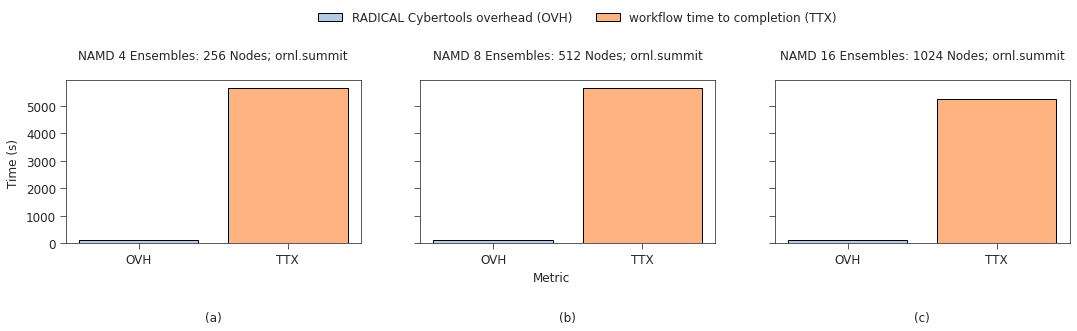

In [15]:
fwidth = 6*len(ovh_rtc.keys())
fheight = 3
fig, axarr = plt.subplots(1, len(ovh_rtc.keys()), sharey=True, figsize=(fwidth, fheight))

i = 0
j = 'a'
for expid in ovh_rtc.keys():
    if len(ovh_rtc.keys()) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('NAMD %s Ensembles: %s Nodes; %s\n' % (
        int(df_info[df_info['exp_id'] == expid]['nodes'].mean()) // 64, 
        int(df_info[df_info['exp_id'] == expid]['nodes'].mean()),
        df_info[df_info['exp_id'] == expid]['resource'].tolist()[0]))

    ax.bar(x = 'OVH', 
           height = df_pcl_overheads[df_pcl_overheads['Exp. ID'] == expid]['OVH'], 
           color = tableau20[1])
    ax.bar(x = 'TTX', 
           height = df_pcl_overheads[df_pcl_overheads['Exp. ID'] == expid]['TTX'], 
           color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text( 0.08,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=12)
fig.text( 0.5 , -0.05, 'Metric'  , ha='center', fontsize=12)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.25), fontsize=12, ncol=2)

plt.savefig('gordonbell_namd_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('gordonbell_namd_ovh_ttx.png', dpi=300, bbox_inches='tight')